<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/LoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# LoF (Local Outlier Factor) による異常検知（初心者向け・1セル版）
# 手順:
# 1) 2次元の正規分布（相関あり）から学習用の「正常」データを作成
# 2) テスト用に「正常＋異常」を混ぜたデータを作成
# 3) 学習データの平均・標準偏差で Z 標準化（スケール合わせ）
# 4) LoF の outlier スコアを計算（大きいほど怪しいように符号を調整）
# 5) 学習スコアの上位 α 分位点をしきい値にして、テストスコアが超えたら異常
# 6) 可視化（元空間の散布図＋しきい値等高線、スコアのヒストグラム）

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:

np.random.seed(0)


In [3]:
# ===== 1) 学習データ（正常）と 2) テストデータ（正常＋異常） =====
k = 20            # 近傍数（10〜30で試すとよい）
alpha = 0.99      # 学習スコアの上位 α 分位点をしきい値に
n_train = 400
n_test_norm = 200
n_test_out = 20

mu = np.array([0.0, 0.0])
Sigma = np.array([[3.0, 2.0],
                  [2.0, 5.0]])   # 非直交（相関あり）

train = np.random.multivariate_normal(mu, Sigma, size=n_train)          # 学習：正常のみ
test_norm = np.random.multivariate_normal(mu, Sigma, size=n_test_norm)  # テスト：正常

# 異常は平均を大きくずらす（分かりやすく）
mu_out = np.array([6.0, -6.0])
Sigma_out = np.array([[1.0, 0.2],
                      [0.2, 1.0]])
test_out = np.random.multivariate_normal(mu_out, Sigma_out, size=n_test_out)

test = np.vstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), dtype=int), np.ones(len(test_out), dtype=int)])  # 0=正常,1=異常(真)

In [4]:
# ===== 3) 学習データで Z 標準化 =====
mu_hat = train.mean(axis=0)
std_hat = train.std(axis=0, ddof=1)
std_hat = np.where(std_hat == 0, 1.0, std_hat)  # 0割り対策

train_z = (train - mu_hat) / std_hat
test_z  = (test  - mu_hat) / std_hat

In [5]:
# ===== 4) LoF outlier スコア =====
# novelty=True: 学習データでfit → 新規データに対してスコア/予測可能
lof = LocalOutlierFactor(n_neighbors=k, novelty=True)
lof.fit(train_z)

# sklearn の score_samples は「大きいほど正常」になりがちなので、符号を反転して
# 「大きいほど異常」のスコアに変換する
score_train = -lof.score_samples(train_z)
score_test  = -lof.score_samples(test_z)

In [6]:
# ===== 5) しきい値＆判定 =====
thr = np.quantile(score_train, alpha)   # 学習スコアの上位 α 分位点
pred = (score_test > thr).astype(int)

# 簡単な集計
tp = ((pred==1) & (labels==1)).sum()
fp = ((pred==1) & (labels==0)).sum()
fn = ((pred==0) & (labels==1)).sum()
precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0

print(f"[LoF] k={k}, alpha={alpha}")
print(f"threshold (quantile on train scores): {thr:.4f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

[LoF] k=20, alpha=0.99
threshold (quantile on train scores): 1.6392
TP=20, FP=3, FN=0
precision=0.870, recall=1.000


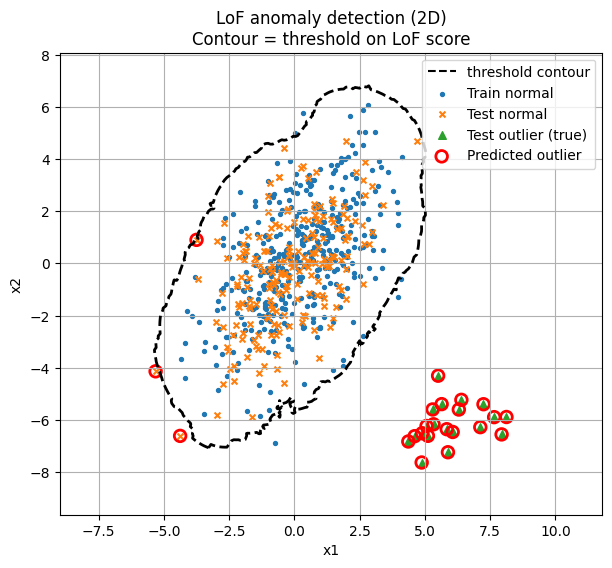

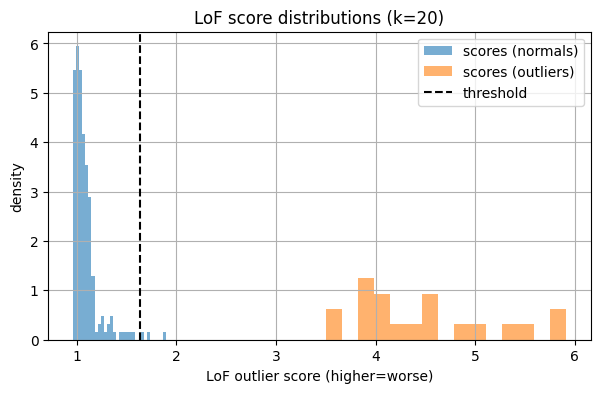

In [7]:
# ===== 6a) 可視化：散布図＋等高線（格子上でスコアを計算）=====
x_min, y_min = (np.min(np.vstack([train, test]), axis=0) - 2)
x_max, y_max = (np.max(np.vstack([train, test]), axis=0) + 2)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_z = (grid - mu_hat) / std_hat

score_grid = -lof.score_samples(grid_z)  # 大きいほど異常
score_grid = score_grid.reshape(xx.shape)

plt.figure(figsize=(7,6))
# 等高線（しきい値）。凡例はダミー線で追加（環境依存属性に触らない）
plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
plt.plot([], [], 'k--', label="threshold contour")

plt.scatter(train[:,0], train[:,1], s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_out[:,0],  test_out[:,1],  s=30, marker='^', label="Test outlier (true)")

# 異常に判定されたテスト点を赤丸で強調
flag_idx = np.where(pred==1)[0]
plt.scatter(test[flag_idx,0], test[flag_idx,1], s=70, facecolors='none',
            edgecolors='red', linewidths=2, label="Predicted outlier")

plt.title("LoF anomaly detection (2D)\nContour = threshold on LoF score")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(loc="best"); plt.grid(True); plt.axis('equal')
plt.show()

# ===== 6b) スコアのヒストグラム =====
plt.figure(figsize=(7,4))
plt.hist(score_test[labels==0], bins=30, density=True, alpha=0.6, label="scores (normals)")
plt.hist(score_test[labels==1], bins=15, density=True, alpha=0.6, label="scores (outliers)")
plt.axvline(thr, linestyle='--', color='k', label="threshold")
plt.title(f"LoF score distributions (k={k})")
plt.xlabel("LoF outlier score (higher=worse)"); plt.ylabel("density")
plt.legend(); plt.grid(True)
plt.show()
